# Machine Learning

[Machine learing](https://en.wikipedia.org/wiki/Machine_learning) is a rapidly developing and maturing field whihc offers tools with incradible power to process data in ways that are incradibly helpful for a wide range of problems in physics.  For the purposes of this notebook we focus on two such aspects: [regression](https://en.wikipedia.org/wiki/Regression_analysis) and [classifcation](https://en.wikipedia.org/wiki/Statistical_classification).  We will make use of the excellent library [scikit-learn](https://scikit-learn.org/stable/).  The documentation for scikit-learn provides exclelent reading if you want a survey of methods and techqnies. 

A listing of papers relevent to machine learning in particle physics can be found [here](https://iml-wg.github.io/HEPML-LivingReview/).




## regression

We will start with a motivational example supplied by [scikit-learn](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_multioutput_face_completion.html#sphx-glr-auto-examples-miscellaneous-plot-multioutput-face-completion-py).   The power of the open sourced tools is incradible.  In this example we will use a linear regression to predict the lower half of faces from the upper half.  We will train on only 5 faces.  Presumably the results would be even moe impressive if we expanded the training set.

We first make sure scikit-learn is up to date, and then load the relevent libraries.  You may have to restart your kernal after this install if you wern't upto date to beigin with.

In [1]:
import sys
!{sys.executable} -m pip install --user --upgrade scikit-learn


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.utils.validation import check_random_state

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

## a motivational example of reconstrucing the bottom half of faces from the top half.  

### load the data set:
Here we load a library of faces.

print the shape of the data and targets arrays
(400, 4096) (400,)
the data has 400 entries, with 4096 data points each
4096 corresponds to a 64x64 image.
ML doesn't know about or care about 2 dimensions


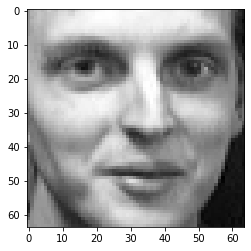

In [3]:
# Load the faces datasets
data, targets = fetch_olivetti_faces(return_X_y=True)



## here is me understanding the data set
print("print the shape of the data and targets arrays")
print(np.shape(data),np.shape(targets))
print("the data has 400 entries, with 4096 data points each")
print("4096 corresponds to a 64x64 image.")
print("ML doesn't know about or care about 2 dimensions") 


## here we reshape the image to 2d so we can plot it, and we plot it
image_shape = (64, 64)
tmp = np.reshape(data[390,:],image_shape)
plt.imshow(tmp,"gray")
plt.show()

## trying to figure out what targets are
#plt.plot(targets)
#plt.title("I have no idea what this means")
#plt.show()

## set up the data set
We are goign to divide the data into a training set and and a validation set 

In [4]:
## divide the data into a training and test data set
train = data[targets < 30]
test = data[targets >= 30]  # Test on independent people


# select on a random subset of people on which to test
n_faces = 5
rng = check_random_state(4)
face_ids = rng.randint(test.shape[0], size=(n_faces,))
test = test[face_ids, :]

## divide these into the uper and lower halfs.
n_pixels = data.shape[1]
# Upper half of the training faces
X_train = train[:, : (n_pixels + 1) // 2]
# Lower half of the training faces
y_train = train[:, n_pixels // 2 :]

# Upper half of the testing faces
X_test = test[:, : (n_pixels + 1) // 2]
# Lower half of the testing faces
y_test = test[:, n_pixels // 2 :]

## we could repet this with left and right side...
##perhaps that is a useful excercise.

## train the model(s) and make predicitons for our test set

This is where the magic happens-- we are going to train 4 differnt linear regression models so we can compare them.  If we were only doing one this would be one line.  I'll put comment arrows to show where the magic happens.  

What we are doing is giving the regression code half the image, and asking it to learn a mapping to preict the other half.  The power of this is that you can give it anything as the input and output varibales.  

For example, we gave the input as simulated beam patterns of an imperfect mirror, and the output as corrections we need to make to fix the mirror surface.   This worked vastly more accurage and quicker than a traditional chi-squared minimizaiton.   Once we had the simulations, it only took a few minuts and a few lines of code.  Our paper can be found [here](https://arxiv.org/abs/2107.04138).

In [5]:
# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=10, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
   }

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(X_train, y_train)  ### <<<<<<<<<<<<<<<<<< EASY!!!!  here is the training
    y_test_predict[name] = estimator.predict(X_test)  ## and here is the estimation


## plot the output

This is just making plots.  It says alot that this is the most complex part of the code.

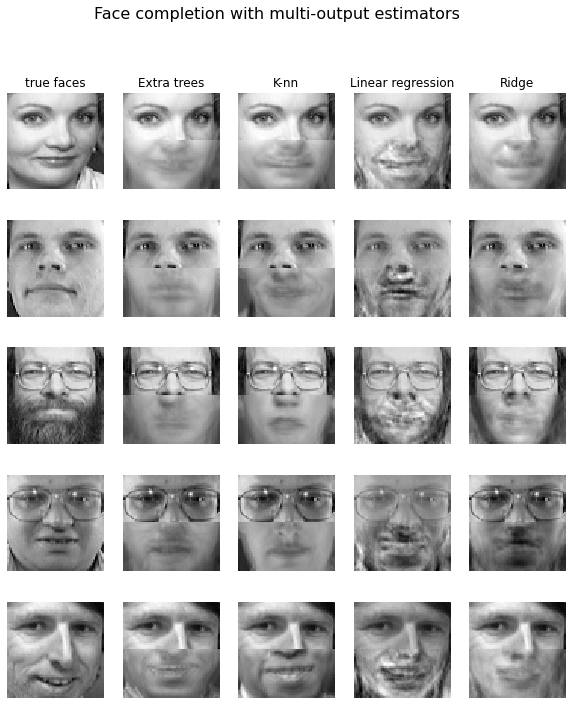

In [6]:
# the shape of the final images (so we can convert from a 1d to an 2d array)
image_shape = (64, 64)

n_cols = 1 + len(ESTIMATORS)
plt.figure(figsize=(2.0 * n_cols, 2.26 * n_faces))
plt.suptitle("Face completion with multi-output estimators", size=16)

for i in range(n_faces):
    true_face = np.hstack((X_test[i], y_test[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1)
    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1, title="true faces")

    sub.axis("off")
    sub.imshow(
        true_face.reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest"
    )

    for j, est in enumerate(sorted(ESTIMATORS)):
        completed_face = np.hstack((X_test[i], y_test_predict[est][i]))

        if i:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j)

        else:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j, title=est)

        sub.axis("off")
        sub.imshow(
            completed_face.reshape(image_shape),
            cmap=plt.cm.gray,
            interpolation="nearest",
        )

plt.show()

### excercise

1. get a photo of your head-- try keep it tight on your face with similar framing.  Make sure your photo is 64x64 pixels and black and white.   See what happens when you input it.  
1. See what happens when you pass in photos with slightly different framings, or non face immages
1. discuss what the two arguemtns to the fit function are and what they could be.

# Example 2: fitting a funciton

here we will generate a funciton $$ f(x) = e^{3x}$$ and fit it first with a linear model, then a polynomial model, and finally a Ridge Regression.

The trik is that we will use machine learning (a neural network) to compute the coefficients of the model from the data, and then predict the function.

In the first eample we used a linear regressio, trained with just seven points.  Each combination x,y of the noisy training set will be used to trian the model.

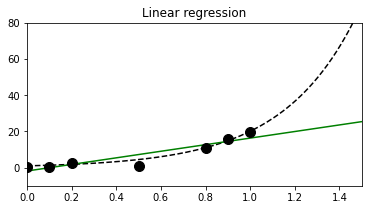

In [7]:
import numpy as np
import scipy.stats as st
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
%matplotlib inline

## define a fucntion
def f(x):
    return np.exp(3 * x)
     
    
## define an underlying true data set
x_tr = np.linspace(0., 2, 200)
y_tr = f(x_tr)


## define measured samples of the data, this will be our training set
x = np.array([0, .1, .2, .5, .8, .9, 1])
y = f(x) + 2 * np.random.randn(len(x))



# We create the model.
lr = lm.LinearRegression()  ## a linear regression 

# We train the model on our training dataset.
lr.fit(x[:, np.newaxis], y[:, np.newaxis])  ##. each x and y point is the training set




# Now, we predict points with our trained model.
y_lr = lr.predict(x_tr[:, np.newaxis])


fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(x_tr, y_tr, '--k')
ax.plot(x_tr, y_lr, 'g')
ax.plot(x, y, 'ok', ms=10)
ax.set_xlim(0, 1.5)
ax.set_ylim(-10, 80)
ax.set_title("Linear regression")
plt.show()

### excercise

Play with the noise level and see how the fucntion does.


Clearly, this linear model isn't good enough.  How can we do better?  Obviusly we need to go beyond linear order.  The way we will do this is by using the np.vander function which will relace x wtih a matrix 1,x,x^2,... and then the regression will fit coefficients to x^n to best model y.    When we evaluate the model we also have to pass in this vander matrix.  This version of a polynomial fit is instructive about how to think about training and use of machine learning regression models.

Note: this model does spit out the coefficients so it is not entirely a black box.

Coefficients, degree 2:
	 32.08 -13.91 0.00
Coefficients, degree 7:
	 890.81 -1985.63 284.17 2279.11 -1959.34 547.60 -37.47 0.00


Text(0.5, 1.0, 'Linear regression')

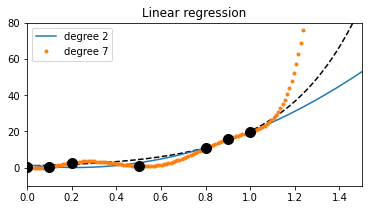

In [8]:
lrp = lm.LinearRegression()

## inititlize the plot
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(x_tr, y_tr, '--k')

for deg, s in zip([2, 7], ['-', '.']):
    
    lrp.fit(np.vander(x, deg + 1), y) ### <<< here is the fit bit
            ## trick-- replace x with a matrix containing 1, x, x**2,... while fixing y
            ## the regression now fits coefficients for each column
            ## this is a polynomial fit!
    y_lrp = lrp.predict(np.vander(x_tr, deg + 1))
    
    ax.plot(x_tr, y_lrp, s,
            label=f'degree {deg}')
    ax.legend(loc=2)
    ax.set_xlim(0, 1.5)
    ax.set_ylim(-10, 80)
    # Print the model's coefficients.
    print(f'Coefficients, degree {deg}:\n\t',
          ' '.join(f'{c:.2f}' for c in lrp.coef_))
ax.plot(x, y, 'ok', ms=10)
ax.set_title("Linear regression")

The degree 2 model is an improvement.  you can see that the degree 7 model is a dissaster.  This is an example of overfitting.  

### excercise 
reduce the degree 7 model to 3 and see if this does better than 2.  What about 4?  What degree does best?



### ridge regression

now we repeat the fit, but using [Ridge regression](https://en.wikipedia.org/wiki/Ridge_regression).  Ridge regression regularizes the data set to deal with degenericies where the input varibales are highly correlated.  You will see it will do a better job at the same order.

Coefficients, degree 3: 10.00 6.82 1.74 0.00
Coefficients, degree 7: 2.14 2.31 2.49 2.66 2.78 2.77 2.45 0.00


/Users/jeff/.local/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1904: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha**-1)


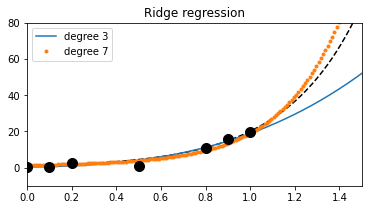

In [9]:

ridge = lm.RidgeCV()

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(x_tr, y_tr, '--k')

for deg, s in zip([3, 7], ['-', '.']):
    ridge.fit(np.vander(x, deg + 1), y)
    y_ridge = ridge.predict(np.vander(x_tr, deg + 1))
    ax.plot(x_tr, y_ridge, s,
            label='degree ' + str(deg))
    ax.legend(loc=2)
    ax.set_xlim(0, 1.5)
    ax.set_ylim(-10, 80)
    # Print the model's coefficients.
    print(f'Coefficients, degree {deg}:',
          ' '.join(f'{c:.2f}' for c in ridge.coef_))

ax.plot(x, y, 'ok', ms=10)
ax.set_title("Ridge regression")
plt.show()

### excercise

see what happens with this model when you go to a degree 20 model.

# Clustering

We now turn to one of the other useful famlies of tools contained within Machiene Learning: [clustering](https://github.com/ipython-books/cookbook-2nd-code/blob/master/chapter08_ml/08_clustering.ipynb). 


## the KMeans clustering algorythem

Here we demonstrate the [KMeans](https://en.wikipedia.org/wiki/K-means_clustering#:~:text=k%2Dmeans%20clustering%20is%20a,a%20prototype%20of%20the%20cluster.) as implimented in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

Miraculously its only required inputs are the number of clusters you expect, and the data you want to categorize.

In [10]:
## read in the relevent libraries
from itertools import permutations
import numpy as np
import sklearn
import sklearn.decomposition as dec
import sklearn.cluster as clu
import sklearn.datasets as ds
import sklearn.model_selection as ms
import matplotlib.pyplot as plt
%matplotlib inline
     

Here we generate some synthetic data X (x,y positions) and the labels for which cluster each data point comes from y.

In [11]:
X, y = ds.make_blobs(n_samples=200,
                     n_features=2,
                     centers=3,
                     cluster_std=1.5,
                     )

## here X is the x,y position of eah of the samples, and
## y identified whihc of the three clusters (labeled 0,1,2) each point is in

## this is how I figured this out.
#print(np.shape(X),np.shape(y))
#print(X)
#print(y)

 the next two funcitons are used only to display the data

In [12]:
def display_clustering(labels, title):   
    """Plot the data points with the cluster
    colors."""

    # We relabel the classes when there are 3 clusters
    labels = relabel(labels)
    fig, axes = plt.subplots(1, 2, figsize=(8, 3),
                             sharey=True)
    # Display the points with the true labels on the
    # left, and with the clustering labels on the
    # right.
    for ax, c, title in zip(
            axes,
            [y, labels],
            ["True labels", title]):
        ax.scatter(X[:, 0], X[:, 1], c=c, s=30,
                   linewidths=0, cmap=plt.cm.rainbow)
        ax.set_title(title)

## cute code to make sure the colors for the predicted groupings match the input.
def relabel(cl):
    """Relabel a clustering with three clusters
    to match the original classes."""
    if np.max(cl) != 2:
        return cl
    perms = np.array(list(permutations((0, 1, 2))))
    i = np.argmin([np.sum(np.abs(perm[cl] - y))
                   for perm in perms])
    p = perms[i]
    return p[cl]

### this is where everythign happens
We are going to set up the KMeans clustering algorthytme to look at the data (x,y) positions only, and sort the data into categories.  Then we hand the data to be fit before plotting it.

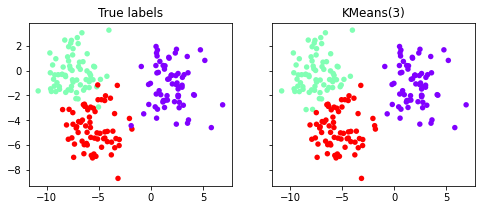

In [13]:

km = clu.KMeans(n_clusters=3,n_init="auto")
km.fit(X)
display_clustering(km.labels_, "KMeans(3)")

remarkablly, this does as well or better than I would have done.  the green points have 100% success, while the red and purble blure near the middle.  It is hard to imagine it doing much better than this.

### excercises: 
1. adjust the n_clusters argument to see what happens with 2, or more than 3
1. consider how this could be used to categorize backrounds in particle searches or other applciations.


One issue with this apporach is that the alogorythem doesn't tell us the probability (or other measure of confidnece) that the categorizaiton is correct.   Conveniently, better methods are available.

# Calibrated Classifiers


addapted from [this example](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration.html#sphx-glr-auto-examples-calibration-plot-calibration-py).

In [14]:
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.naive_bayes import GaussianNB

from matplotlib import cm
import matplotlib.pyplot as plt

 generate a data set with three blobs, of which two are indpendant, and the third is composed of samples with equal probability of being from eother of the two seperated blobs.  We will use the same functions as before, but with slightly different arguments.

In [15]:

n_samples = 50000
n_bins = 3  # use 3 bins for calibration_curve as we have 3 clusters here

# Generate 3 blobs with 2 classes where the second blob contains
# half positive samples and half negative samples. Probability in this
# blob is therefore 0.5.
centers = [(-5, -5), (0, 0), (5, 5)]
X, y = make_blobs(n_samples=n_samples, centers=centers, shuffle=False, random_state=42)
## the trick here is that we set shuffle = False
## this means the data are ordered blob 0, blob 1, blob 2. 
## Therefor if we replace y with an array with the first half 0 and the second half 1
## we will get the starting point we want
## scroll to the end to see how this looks.
y[: n_samples // 2] = 0
y[n_samples // 2 :] = 1


                                                                    

next we set up a sample_weight array, and then devide the data into training and test arrays.  We will savel 90% of the data for the tests.

In [16]:
## for later use.
sample_weight = np.random.RandomState(42).rand(y.shape[0])
        ## it is unclear to me why this is a random weight.  
        ## I would have thought unifrom.

# split train, test for calibration
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
                                                           X, y, sample_weight, 
                                                            test_size=0.9, 
                                                            random_state=42
                                                                        )


now we wil train and run the models on the test data set.  Not it is very simple, except we are testing several different models.  



In [17]:
# With no calibration
clf = GaussianNB()
clf.fit(X_train, y_train)  # GaussianNB itself does not support sample-weights
prob_pos_clf = clf.predict_proba(X_test)[:, 1]

# With isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=2, method="isotonic")
clf_isotonic.fit(X_train, y_train, sample_weight=sw_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

# With sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(clf, cv=2, method="sigmoid")
clf_sigmoid.fit(X_train, y_train, sample_weight=sw_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

print("Brier score losses: (the smaller the better)")

clf_score = brier_score_loss(y_test, prob_pos_clf, sample_weight=sw_test)
print("No calibration: %1.3f" % clf_score)

clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic, sample_weight=sw_test)
print("With isotonic calibration: %1.3f" % clf_isotonic_score)

clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid, sample_weight=sw_test)
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)

Brier score losses: (the smaller the better)
No calibration: 0.104
With isotonic calibration: 0.084
With sigmoid calibration: 0.109


Now make plots

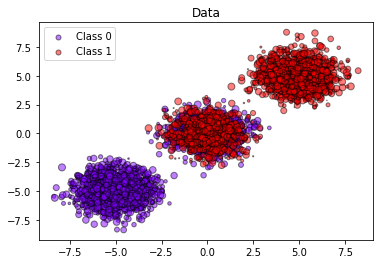

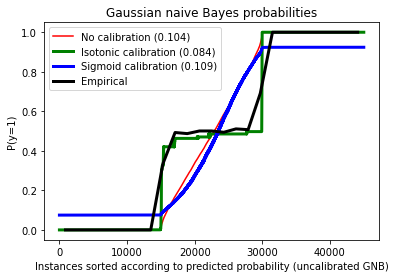

In [18]:
plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(
        this_X[:, 0],
        this_X[:, 1],
        s=this_sw * 50,
        c=color[np.newaxis, :],
        alpha=0.5,
        edgecolor="k",
        label="Class %s" % this_y,
    )
plt.legend(loc="best")
plt.title("Data")

plt.figure()

order = np.lexsort((prob_pos_clf,))
plt.plot(prob_pos_clf[order], "r", label="No calibration (%1.3f)" % clf_score)
plt.plot(
    prob_pos_isotonic[order],
    "g",
    linewidth=3,
    label="Isotonic calibration (%1.3f)" % clf_isotonic_score,
)
plt.plot(
    prob_pos_sigmoid[order],
    "b",
    linewidth=3,
    label="Sigmoid calibration (%1.3f)" % clf_sigmoid_score,
)
plt.plot(
    np.linspace(0, y_test.size, 51)[1::2],
    y_test[order].reshape(25, -1).mean(1),
    "k",
    linewidth=3,
    label=r"Empirical",
)
plt.ylim([-0.05, 1.05])
plt.xlabel("Instances sorted according to predicted probability (uncalibrated GNB)")
plt.ylabel("P(y=1)")
plt.legend(loc="upper left")
plt.title("Gaussian naive Bayes probabilities")

plt.show()

It is pretty impressive that this works so well and so quickly out of the box.  This, and the associated probability would be very useful in a number of experimental applicaitons.

### excercises
1. switch the weights to uniform, see what breaks
1. convert the input data set to two overlapping gaussians, perhaps of different widths, see what happens
1. play